### Human in the loop 

Review for human in the loop, we often want to see our graph outputs as its running.

we laid the foundations for this with streaming. 

Goals now , lets talk about the motivations for human in the loop:

1. Approval : we can interrupt out agent, surface state to a user , and allow the user to accept an action

2. debugging : we can rewind the graph to reproduce or avoid issues. 

3. editing : you can modify the state

LangGraph offers several ways to get or update agent state to support various human in the loop workflows.

In [1]:
from dotenv import load_dotenv
load_dotenv()

import os 

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API")

In [2]:
llm=ChatGroq(model="openai/gpt-oss-20b")

In [3]:
### custom tools 

def multiply(a: int,b:int) -> int:
    """Multiply a and b
    Args:
        a (int): first number
        b (int): second number
    Returns:
        int: product of a and b
    """
    return a*b
def add(a: int,b:int) -> int:
    """Add a and b
    Args:
        a (int): first number
        b (int): second number
    Returns:
        int: sum of a and b
    """
    return a+b
def subtract(a: int,b:int) -> int:
    """Subtract b from a
    Args:
        a (int): first number
        b (int): second number
    Returns:
        int: difference of a and b
    """
    return a-b
def divide(a: int,b:int) -> float:
    """Divide a by b
    Args:
        a (int): first number
        b (int): second number
    Returns:
        float: quotient of a and b
    """
    if b==0:
        return "Division by zero is not allowed"
    return a/b

tools=[add,subtract,multiply,divide]
tools

[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.subtract(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> float>]

In [5]:
## integrate tools with llm 

llm_with_tools=llm.bind_tools(tools)

In [6]:
### workflow with LangGraph

from IPython.display import Image,display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage


### system message 

sys_msg=SystemMessage(content="you are a helpful assistant tasked with performing arithmetic on a set of inputs.")

In [7]:
## nodes 

def assistant(state:MessagesState):
    return{"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}



In [10]:
builder=StateGraph(MessagesState)

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"assistant")
builder.add_conditional_edges("assistant",tools_condition,)
builder.add_edge("tools","assistant")

memory=MemorySaver()

## human in the loop

graph=builder.compile(interrupt_before=["assistant"],checkpointer=memory)



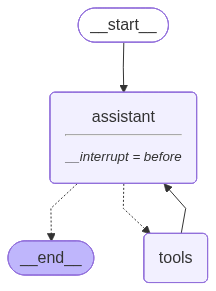

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
thread={"configurable":{"thread_id":"123"}}

initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}
 


In [13]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
